In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, mannwhitneyu, skew, fisher_exact, chi2_contingency, bootstrap, permutation_test
from statsmodels.stats.proportion import proportions_ztest

from sklearn.datasets import make_classification

In [2]:
def evaluate_groups(
    df, 
    target_col='target', 
    value_col='gross_summ', 
    n_iter=None, 
    plot=True, 
    alternative="two-sided",
    confidence_level=0.95,
    permutation_type='independent',
    bootstrap_method='BCa',
    mode='number'
):
    """
    Оцінює різницю між двома групами (target vs control) за допомогою бутстрепу 
    та статистичних тестів. Підтримує як числові, так і бінарні метрики.
    
    Параметри
    ---------
    df : pandas.DataFrame
        Вхідний датафрейм з даними, що містить стовпці для групування та метрики.
    
    target_col : str, за замовчуванням 'target'
        Назва стовпця, що визначає групу. 
        Очікується, що там є два значення: 
        - 1 для target (експериментальної групи),
        - 0 для control (контрольної групи).
    
    value_col : str, за замовчуванням 'gross_summ'
        Назва стовпця з метрикою/значеннями, які потрібно порівняти між групами.
    
    n_iter : int, за замовчуванням 1% розміру датафрейму
        Кількість ітерацій бутстрепу (перегенерацій випадкових вибірок).
        Якщо None → використовується 1/100 від розміру всього датафрейму.

    plot : bool, за замовчуванням True
        Якщо True → будується гістограма розподілу різниць середніх, 
        з позначенням середнього значення та довірчого інтервалу.
    
    alternative : {'two-sided', 'greater', 'less'}, за замовчуванням 'two-sided'
        Тип статистичного тесту:
        - 'two-sided' → перевіряється, чи відрізняються середні (будь-який напрямок).
        - 'greater' → перевіряється, чи середнє у групі target > control.
        - 'less' → перевіряється, чи середнє у групі target < control.

    confidence_level : float, за замовчуванням 0.95
        Рівень довіри для бутстрепного довірчого інтервалу (наприклад, 0.95 для 95% CI).

    permutation_type : {'independent', 'paired', 'samples'}, за замовчуванням 'independent'
        Тип пермутаційного тесту:
        - 'independent' → для незалежних вибірок (дві окремі групи).
        - 'paired' → для залежних вибірок (парні спостереження).
        - 'samples' → для загальних випадків (всі спостереження в одному наборі).

    bootstrap_method : {'basic', 'percentile', 'BCa'}, за замовчуванням 'BCa'
        Метод обчислення бутстрепного довірчого інтервалу:
        - 'basic' → базовий метод.
        - 'percentile' → перцентильний метод.
        - 'BCa' → скоригований і прискорений метод (зазвичай найкращий).

    mode : {'number', 'binary'}, за замовчуванням 'number'
        Тип метрики:
        - 'number' → числова метрика (використовуються t-тест і Манна-Вітні).
        - 'binary' → бінарна метрика (використовуються Z-тест для пропорцій і тест Фішера).
        Логіка бутстрепу залишається однаковою для обох типів.
    
Повертає
--------
pandas.DataFrame
    Таблиця з результатами A/B-порівняння між групами target і control, що містить
    оцінку ефекту, бутстрепний довірчий інтервал і набір статистичних тестів,
    підібраних відповідно до типу метрики.

    Загальні поля
    -------------
    - Metric/Field : назва метрики (value_col)
    - Mean Difference : середня різниця між групами (target − control)
    - CI Lower : нижня межа 95% бутстрепного довірчого інтервалу
    - CI Upper : верхня межа 95% бутстрепного довірчого інтервалу
    - Cohen's d : стандартизований розмір ефекту (для числових метрик)
        ≈0   → практично відсутній ефект  
        0.2  → малий ефект  
        0.5  → середній ефект  
        0.8+ → великий ефект  

    Числові метрики (mode='number')
    ------------------------------
    Для безперервних величин (revenue, deposit, LTV тощо) використовуються:

    - T-test p-value (alternative)  
      Класичний t-тест для різниці середніх.
      Коректний, якщо розподіли близькі до нормальних або вибірки великі
      (центральна гранична теорема).

    - Mann-Whitney p-value (alternative)  
      Непараметричний тест.
      Порівнює медіани та загальну форму розподілів, не вимагає нормальності.
      Стійкий до перекосів, хвостів і викидів.

    Разом t-test і Mann-Whitney дають:
    - t-test → «чи різняться середні?»
    - Mann-Whitney → «чи системно одна група більша за іншу?»

    Бінарні метрики (mode='binary')
    -------------------------------
    Для метрик типу conversion, deposited, clicked (0/1) будується 2×2 таблиця
    “успіх / неуспіх × група”, і застосовуються:

    - Z-test p-value (alternative)  
      Асимптотичний тест для різниці пропорцій.
      Добре працює при великих вибірках і не надто малих конверсіях.

    - Chi² p-value  
      Класичний χ²-тест незалежності для contingency table.
      Стандартний інструмент A/B-тестування пропорцій.
      Стійкий і на великих вибірках практично еквівалентний Z-test
      (для 2×2 таблиці Z² ≈ χ²).

    - Fisher p-value (alternative)  
      Точний тест для 2×2 таблиць.
      Використовується, коли вибірки малі або є дуже рідкісні події
      (очікувані частоти близькі до нуля).

    Разом ці тести дають:
    - Z / Chi² → швидка й стабільна перевірка на великих даних
    - Fisher → надійний «страхувальний» варіант, коли даних мало

    Інтерпретація
    -------------
    - Бутстрепний CI показує емпіричний розподіл різниці.
      Якщо 0 не входить у CI → ефект статистично значущий.
    - Статистичні тести відповідають на питання
      «чи могла така різниця виникнути випадково».
    - Cohen’s d (для числових метрик) показує практичну важливість ефекту,
      незалежно від розміру вибірки.

    Якщо mode='number', також повертаються статистики розподілу:
    - target_skew / control_skew : асиметрія розподілу
        - ≈0 → симетричний розподіл
        - >0 → права «хвістова» асиметрія (значення з великими викидами)
        - <0 → ліва «хвістова» асиметрія (значення з маленькими викидами)
    - target_kurtosis / control_kurtosis : куртозис
        - ≈0 → розподіл схожий на нормальний
        - >0 → гострий пік та важкі хвости (часто екстремальні значення)
        - <0 → плоский розподіл, легкі хвости

    Якщо mode='binary', повертаються пропорції та розміри вибірок:
        - target_prop / control_prop : пропорція успіхів (середнє бінарної метрики)
        - target_count / control_count : розмір вибірки кожної групи

    графік (якщо plot=True)
        - Гістограми розподілів середніх для кожної групи з позначенням їх довірчих інтервалів.

        - Гістограма розподілу різниць середніх з позначенням середнього та довірчого інтервалу.
        Якщо нуль поза межами довірчого інтервалу → можна вважати, що різниця статистично значуща.

        - Гістограма розподілу різниць середніх з пермутаційного тесту (метод рестановки)
        з позначенням спостережуваної різниці та довірчивого інтервалу.
        Якщо нуль поза межами довірчого інтервалу → можна вважати, що різниця статистично значуща.

    Зауваження
    ----------
    - t-тест вважає, що дані приблизно нормально розподілені, хоча може бути стійким до відхилень.
    - Критерій Манна-Вітні не робить припущень про нормальність і підходить для порівняння медіан.
    - Усі p-value за замовчуванням двосторонні, якщо не вказати інше через `alternative`.
    - Cohen's d дає уявлення про практичну значущість різниці, незалежно від розміру вибірки.
    - Для бінарних метрик Z-тест і тест Фішера оцінюють різницю пропорцій між групами.
    
    Приклади
    --------
    >>> evaluate_groups(df, value_col="revenue", alternative="two-sided")
    >>> evaluate_groups(df, mode='binary', value_col="conversion", n_iter=500, alternative="greater", plot=False)
    """

    tr_values = df[df[target_col] == 1][value_col].values
    co_values = df[df[target_col] == 0][value_col].values

    n_iter = n_iter if n_iter else max(100, int(len(df) / 100))

    # --- Bootstrap ---
    bootstrap_res = bootstrap(
        (tr_values, co_values),
        statistic=lambda x, y: x.mean() - y.mean(),
        n_resamples=n_iter,
        confidence_level=confidence_level,
        alternative=alternative,
        method=bootstrap_method
    )
    ci_lower, ci_upper = bootstrap_res.confidence_interval
    diffs = bootstrap_res.bootstrap_distribution
    mean_delta = np.mean(diffs)

    # --- Target & Control ---
    bootstrap_res_tr = bootstrap(
        (tr_values,),
        statistic=lambda x: x.mean(),
        n_resamples=n_iter,
        confidence_level=confidence_level,
        alternative=alternative,
        method=bootstrap_method
    )
    tr_ci_lower, tr_ci_upper = bootstrap_res_tr.confidence_interval
    tr_means = bootstrap_res_tr.bootstrap_distribution

    bootstrap_res_co = bootstrap(
        (co_values,),
        statistic=lambda x: x.mean(),
        n_resamples=n_iter,
        confidence_level=confidence_level,
        alternative=alternative,
        method=bootstrap_method
    )
    co_ci_lower, co_ci_upper = bootstrap_res_co.confidence_interval
    co_means = bootstrap_res_co.bootstrap_distribution

    # --- Permutation test ---
    permutation_res = permutation_test(
        (tr_values, co_values),
        statistic=lambda x, y: x.mean() - y.mean(),
        n_resamples=n_iter,
        alternative=alternative,
        permutation_type=permutation_type
    )
    p_perm = permutation_res.pvalue
    perm_diffs = permutation_res.null_distribution
    perm_ci_lower, perm_ci_upper = np.percentile(perm_diffs, [2.5, 97.5])
    perm_statistic = permutation_res.statistic

    # --- Statistical tests ---
    cohen_d = (
        (np.mean(tr_values) - np.mean(co_values)) /
        np.sqrt((np.var(tr_values) + np.var(co_values)) / 2)
    )

    # --- Distribution stats ---
    if mode == 'number':
        t_stat, t_p = ttest_ind(tr_values, co_values, alternative=alternative)
        mw_stat, mw_p = mannwhitneyu(tr_values, co_values, alternative=alternative)

        stats_number = {
            'target_skew': skew(tr_values),
            'control_skew': skew(co_values),
            'target_kurtosis': pd.Series(tr_values).kurtosis(),
            'control_kurtosis': pd.Series(co_values).kurtosis(),
        }

        p_values_number = {
            f'T-test p-value ({alternative})': round(t_p, 3),
            f'Mann-Whitney p-value ({alternative})': round(mw_p, 3),
        }
        
    elif mode == 'binary':
        # --- Z-test для пропорцій ---
        count = np.array([tr_values.sum(), co_values.sum()])
        nobs = np.array([len(tr_values), len(co_values)])
        alternative_dict = {
            "two-sided": "two-sided",
            "greater": "larger",
            "less": "smaller"
        }
        alternative_ztest = alternative_dict.get(alternative, "two-sided")
        z_stat, z_p = proportions_ztest(count, nobs, alternative=alternative_ztest)
        
        # --- Fisher exact test ---
        table = np.array([
            [tr_values.sum(), len(tr_values)-tr_values.sum()],
            [co_values.sum(), len(co_values)-co_values.sum()]
        ])
        _, p_fisher = fisher_exact(table, alternative=alternative)

        # --- Chi-square test ---
        chi2, p_chi2, dof, expected = chi2_contingency(table)

        stats_binary = {
            'target_prop': round(tr_values.mean(), 3),
            'control_prop': round(co_values.mean(), 3),
            'target_count': len(tr_values),
            'control_count': len(co_values)
        }

        p_values_binary = {
        f'Z-test p-value ({alternative})': round(z_p, 3),
        f'Chi² p-value': round(p_chi2, 3),
        f'Fisher p-value ({alternative})': round(p_fisher, 3),
        }

    result = {
        'Metric/Field': value_col,
        'Mean Difference': round(mean_delta, 3),
        'CI Lower': ci_lower,
        'CI Upper': ci_upper,
        "Cohen's d": round(cohen_d, 3)
    }

    result = result | (stats_number if mode == 'number' else stats_binary)
    result = result | (p_values_number if mode == 'number' else p_values_binary)

    # --- Common x-axis limits for group means ---
    x_min = min(np.min(tr_means), np.min(co_means))
    x_max = max(np.max(tr_means), np.max(co_means))

    pad = 0.05 * (x_max - x_min)
    x_min -= pad
    x_max += pad

    # --- Plot ---
    if plot:
        def draw_ci(ax, low, high, data, color):
            # межі тільки для графіка
            lo = low if np.isfinite(low) else data.min()
            hi = high if np.isfinite(high) else data.max()

            ax.axvspan(lo, hi, color=color, alpha=0.2)

            # візуальні маркери "нескінченності"
            if not np.isfinite(low):
                ax.axvline(lo, color=color, linestyle=':', linewidth=2)
            if not np.isfinite(high):
                ax.axvline(hi, color=color, linestyle=':', linewidth=2)

        fig, axes = plt.subplots(4, 1, figsize=(9, 8))

        # === Target mean ===
        axes[1].hist(tr_means, bins=30, density=True, color='orange', edgecolor='black')
        axes[1].axvline(np.mean(tr_means), color='red', linestyle='--', linewidth=2)

        draw_ci(axes[1], tr_ci_lower, tr_ci_upper, np.array(tr_means), 'orange')

        axes[1].set_title(f'Target mean = {np.mean(tr_means):.2f}')
        axes[1].set_xlim(x_min, x_max)

        # === Control mean ===
        axes[0].hist(co_means, bins=30, density=True, color='steelblue', edgecolor='black')
        axes[0].axvline(np.mean(co_means), color='red', linestyle='--', linewidth=2)

        draw_ci(axes[0], co_ci_lower, co_ci_upper, np.array(co_means), 'steelblue')

        axes[0].set_title(f'Control mean = {np.mean(co_means):.2f}')
        axes[0].set_xlim(x_min, x_max)

        # === Difference of means ===
        axes[2].hist(diffs, bins=30, density=True,
                     color='gray', edgecolor='black')
        axes[2].axvline(mean_delta,
                        color='red', linestyle='--', linewidth=2,
                        label=f'Mean diff: {mean_delta:.2f}')
        
        draw_ci(axes[2], ci_lower, ci_upper, np.array(diffs), 'gray')
        
        axes[2].axvline(0, color='black', linewidth=1)
        axes[2].set_title(
            f'Difference of means: {mean_delta:.2f} '
            f'CI [{ci_lower:.2f}, {ci_upper:.2f}]'
            )
        
        # --- Permutation test plot ---
        axes[3].hist(perm_diffs, bins=30, color='grey',
                    edgecolor='black', density=True)
        axes[3].axvline(perm_statistic, color='red', linestyle='--', linewidth=2,
                        label=f'Observed diff: {perm_statistic:.2f}')
        axes[3].axvspan(perm_ci_lower, perm_ci_upper, color='grey', alpha=0.25,
                        label='95% CI')
        axes[3].axvline(0, color='black', linewidth=1)
        axes[3].set_title(
            f'Permutation test observed diff: {perm_statistic:.2f} (p-value = {p_perm:.3f})'
        )
        axes[3].grid(alpha=0.2)

        for ax in axes:
            ax.grid(alpha=0.2)

        plt.tight_layout()
        plt.show()

    return result

# числові значення

In [3]:
X, y = make_classification(
    n_samples=10000,
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_clusters_per_class=4,
    random_state=42
)

gross_summ = X[:, 0]*50 + np.random.normal(0, 15, size=10000) 
gross_summ += np.where(y==1, 25, 0)

df_fake = pd.DataFrame({
    'user_id': np.random.randint(1, 200, size=10000),
    'gross_summ': np.abs(gross_summ),
    'target': y
})

df_fake.head()

,user_id,gross_summ,target
0,179,87.277630,0
1,184,49.149082,0
2,132,16.046426,1
3,39,31.049447,0
4,66,31.781830,1


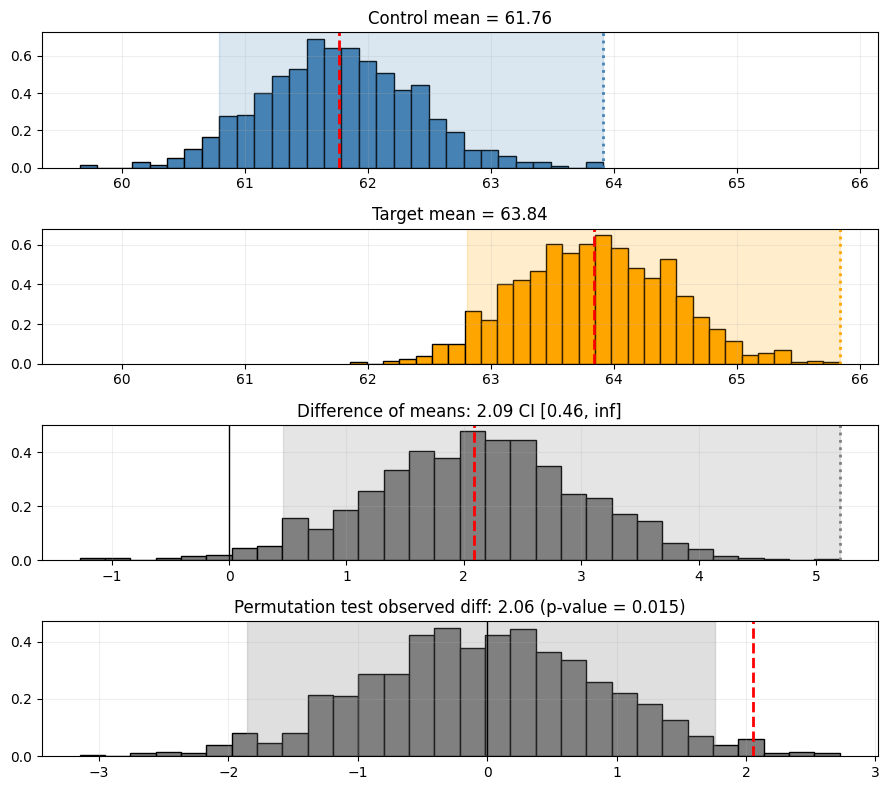

{'Metric/Field': 'gross_summ',
 'Mean Difference': 2.086,
 'CI Lower': 0.4611277182260149,
 'CI Upper': array(inf),
 "Cohen's d": 0.046,
 'target_skew': 0.8759714979499139,
 'control_skew': 0.7933400216094438,
 'target_kurtosis': 0.6640542853487861,
 'control_kurtosis': 0.2552218814536986,
 'T-test p-value (greater)': 0.011,
 'Mann-Whitney p-value (greater)': 0.083}

In [4]:
res = evaluate_groups(df_fake, alternative="greater", plot=True, value_col='gross_summ', n_iter=1000)
res

# бінарні значення

In [5]:
X, y = make_classification(
    n_samples=10000,
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=42
)

conversion = np.zeros(10000, dtype=int)
conversion[y == 0] = np.random.binomial(1, 0.3, size=(y==0).sum())
conversion[y == 1] = np.random.binomial(1, 0.32, size=(y==1).sum())

df_fake = pd.DataFrame({
    'user_id': np.random.randint(1, 200, size=10000),
    'conversion': conversion,
    'target': y
})

df_fake.head()

,user_id,conversion,target
0,129,0,0
1,15,1,1
2,50,1,0
3,141,0,0
4,141,0,0


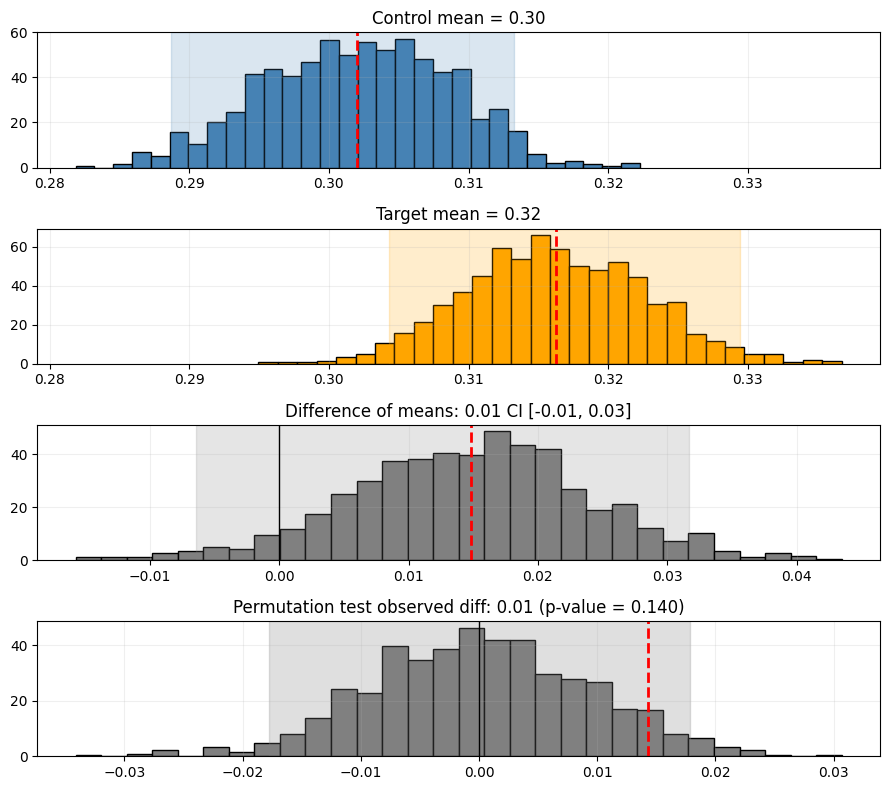

{'Metric/Field': 'conversion',
 'Mean Difference': 0.015,
 'CI Lower': -0.006455631571463336,
 'CI Upper': 0.03164050934529882,
 "Cohen's d": 0.031,
 'target_prop': 0.316,
 'control_prop': 0.302,
 'target_count': 5001,
 'control_count': 4999,
 'Z-test p-value (two-sided)': 0.122,
 'Chi² p-value': 0.128,
 'Fisher p-value (two-sided)': 0.124}

In [6]:
res = evaluate_groups(df_fake, value_col='conversion', n_iter=1000, mode='binary', plot=True)
res